In [2]:
from pathlib import Path
from typing import List
from trap.frame_emitter import Track
from trap.frame_emitter import Camera
from trap.tracker import TrackReader


path = Path("EXPERIMENTS/raw/hof3/")
calibration_path = Path("../DATASETS/hof3/calibration.json")
homography_path = Path("../DATASETS/hof3/homography.json")
camera = Camera.from_paths(calibration_path, homography_path, 12)


In [3]:
reader = TrackReader(path, camera.fps, exclude_whitelisted = False, include_blacklisted=False)

In [4]:
from trap.tracker import FinalDisplacementFilter


tracks: List[Track] = [t for t in reader]
filter = FinalDisplacementFilter(2)
tracks = filter.apply(tracks, camera)

In [5]:
tracks[0]

Track(track_id='7', history=[Detection(track_id='7', l=1320.8199462890625, t=251.9683380126953, w=111.053955078125, h=234.67745971679688, conf=1, state=<DetectionState.Confirmed: 2>, frame_nr=3264, det_class=1), Detection(track_id='7', l=1339.9742431640625, t=238.920166015625, w=105.037109375, h=222.37574768066406, conf=1, state=<DetectionState.Confirmed: 2>, frame_nr=3265, det_class=1), Detection(track_id='7', l=1352.3323974609375, t=229.05804443359375, w=104.625732421875, h=221.97633361816406, conf=1, state=<DetectionState.Confirmed: 2>, frame_nr=3266, det_class=1), Detection(track_id='7', l=1359.267822265625, t=220.7544708251953, w=106.5965576171875, h=226.98056030273438, conf=1, state=<DetectionState.Confirmed: 2>, frame_nr=3267, det_class=1), Detection(track_id='7', l=1362.710693359375, t=213.61810302734375, w=109.2371826171875, h=233.524169921875, conf=1, state=<DetectionState.Confirmed: 2>, frame_nr=3268, det_class=1), Detection(track_id='7', l=1364.126708984375, t=203.141204833

In [6]:

from trap.tracker import Smoother


smoother = Smoother(12, convolution=True)

In [7]:
import cv2
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import tqdm


  0%|          | 0/2682 [00:00<?, ?it/s]

100%|██████████| 2682/2682 [00:26<00:00, 100.91it/s]


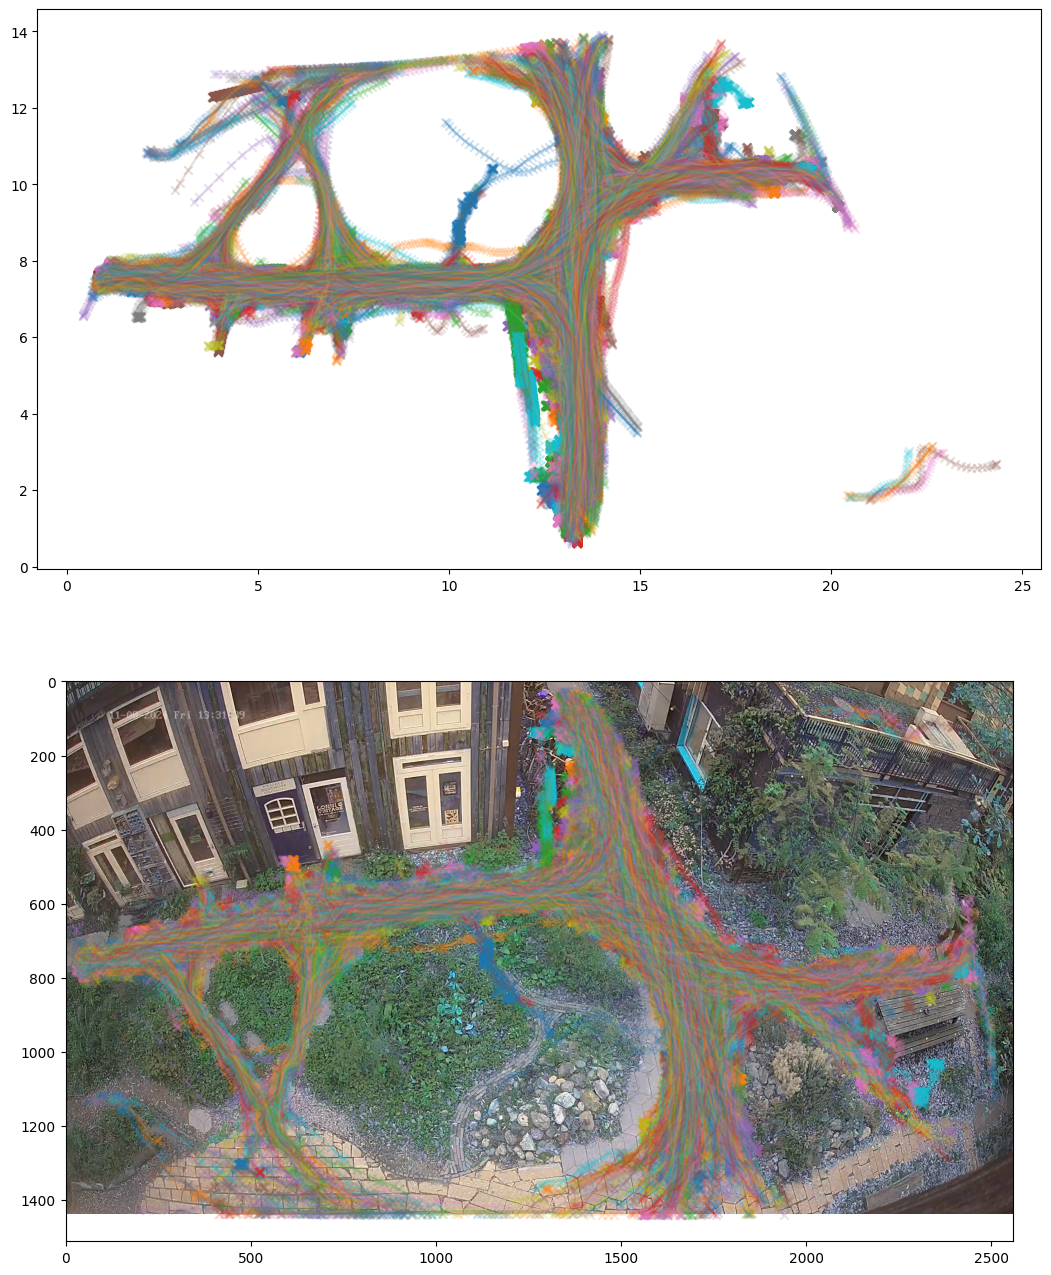

In [8]:

fig = plt.figure(figsize=(20,16))
ax1, ax2 = fig.subplots(2)

im = cv2.imread("../DATASETS/hof3/output.png")
ax2.imshow(im)
ax1.set_aspect(1)
ax2.set_aspect(1)



for track in (bar:= tqdm.tqdm(tracks)):
    t = track.get_with_interpolated_history()
    t = smoother.smooth_track(t)
    points = t.get_projected_history(None, camera)
    x, y = points[:,0], points[:,1]
    ax1.plot(x, y, alpha=.2)
    ax1.scatter(x, y, marker='x', alpha=.2)
    l = [d.get_foot_coords()[0] for d in track.history]
    t = [d.get_foot_coords()[1] for d in track.history]
    ax2.plot(l, t, alpha=.2)
    ax2.scatter(l, t, marker='x', alpha=.2)
    # if bar.n > 100:
    #     break

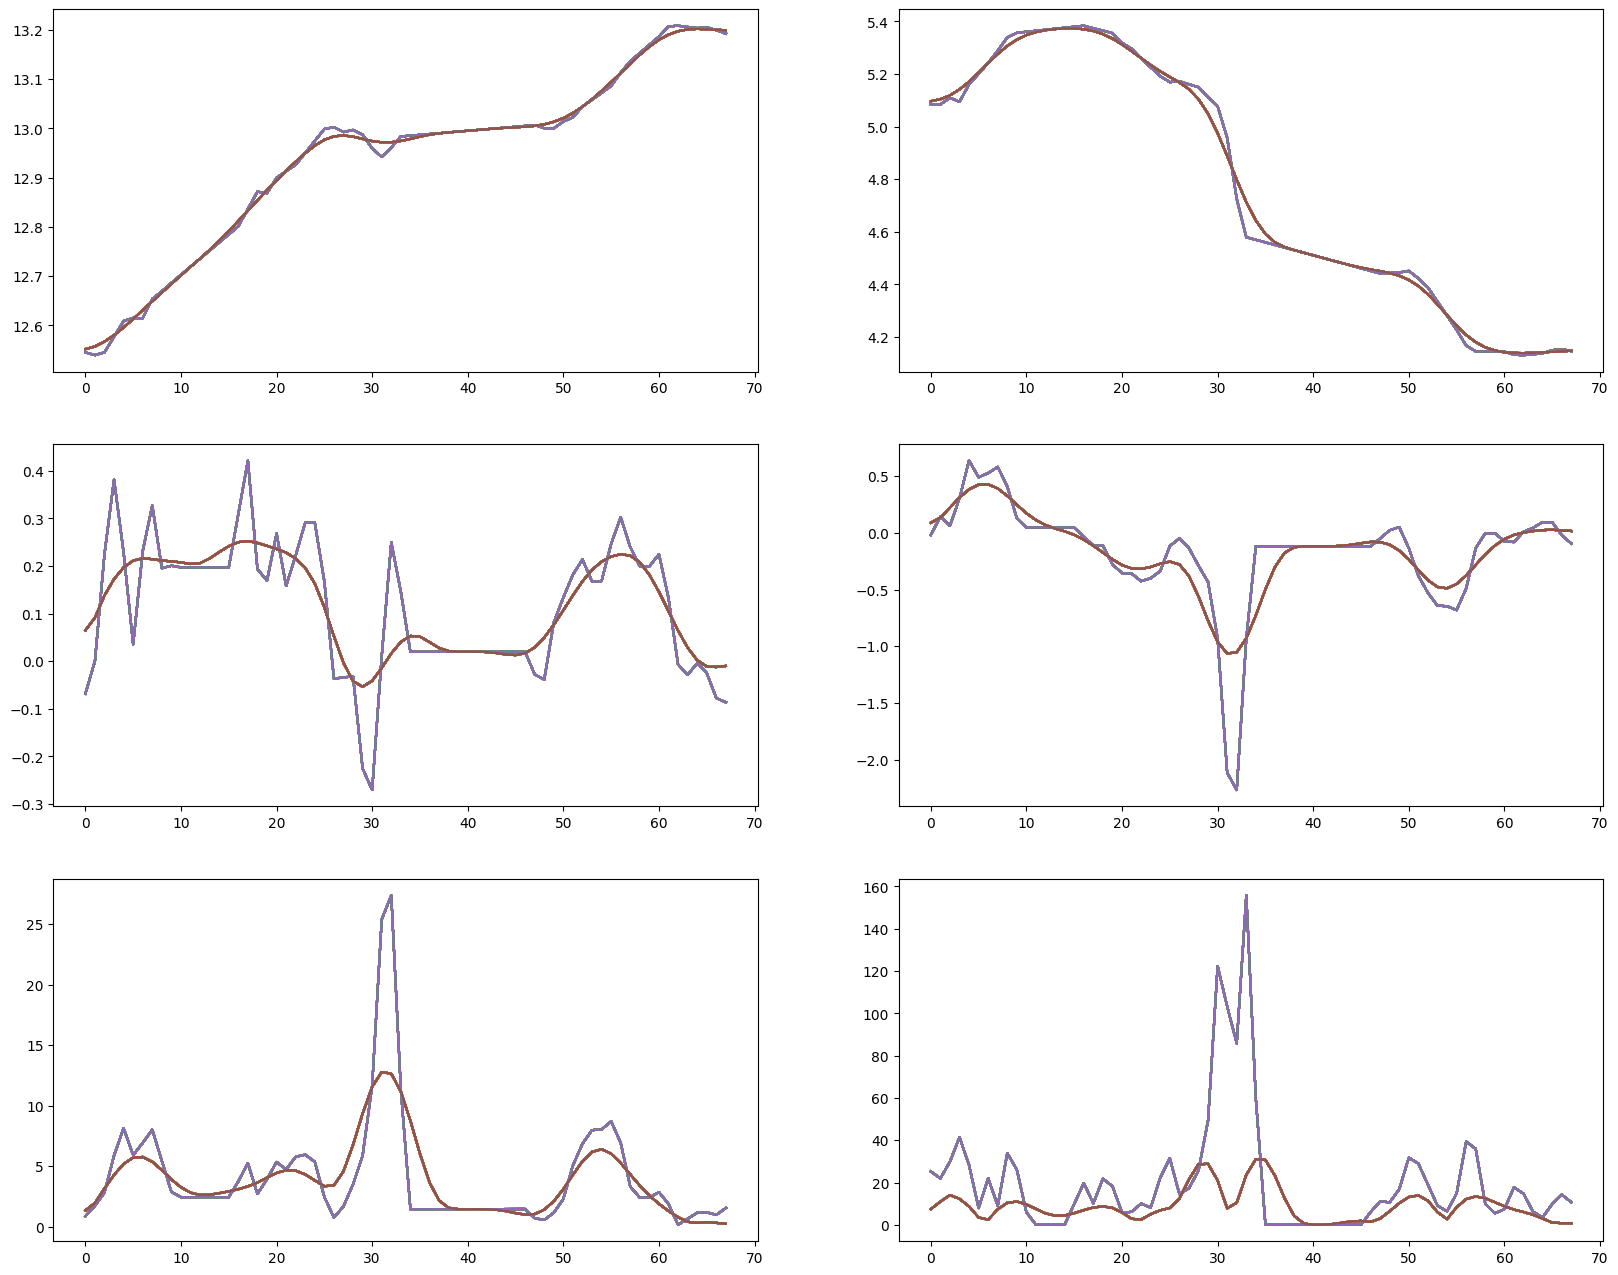

In [10]:
import numpy as np
from trajectron.environment import Environment

from trap.tracker import Smoother
env = Environment(node_type_list=['PEDESTRIAN'], standardization=None)
n = 9
# n = 20
# n = 21
# print([d.frame_nr for d in tracks[n].history])
track = tracks[n].get_with_interpolated_history()
node_s = smoother.smooth_track(track).to_trajectron_node(camera, env)
node_o = track.to_trajectron_node(camera, env)
# print(node.data[:, {'velocity': ['x', 'y']}] * 12)

fig = plt.figure(figsize=(20,16))
(ax1, ax2), (ax3, ax4), (ax5, ax6) = fig.subplots(3,2)

for i in range(len(track.history)):
    ax1.plot(node_o.data[:, {'position': ['x']}])
    ax1.plot(node_s.data[:, {'position': ['x']}])
    ax2.plot(node_o.data[:, {'position': ['y']}])
    ax2.plot(node_s.data[:, {'position': ['y']}])
    ax3.plot(node_o.data[:, {'velocity': ['x']}])
    ax3.plot(node_s.data[:, {'velocity': ['x']}])
    ax4.plot(node_o.data[:, {'velocity': ['y']}])
    ax4.plot(node_s.data[:, {'velocity': ['y']}])
    ax5.plot(np.linalg.norm(node_o.data[:, {'velocity': ['x', 'y']}], axis=1) * 12)
    ax5.plot(np.linalg.norm(node_s.data[:, {'velocity': ['x', 'y']}], axis=1) * 12)
    
    ax6.plot(np.linalg.norm(node_o.data[:, {'acceleration': ['x', 'y']}], axis=1) * 12)
    ax6.plot(np.linalg.norm(node_s.data[:, {'acceleration': ['x', 'y']}], axis=1) * 12)
    # np.linalg.norm(node.data[:, {'acceleration': ['x', 'y']}], axis=1) * 12
# node.data[:, {'acceleration': ['x', 'y']}]